In [ ]:
pip install pandas-datareader

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
from datetime import datetime
from MCForecastTools import MCSimulation
import requests
import pandas_datareader as pdr
%matplotlib inline

In [2]:
# Function to Validate Tickers
def validateTick(tick):
    
    # Try Inputting into Yahoo Stocks
    try:
        pdr.DataReader(f'{tick}','yahoo',date)
    
    # Raise Error if Invalid
    except:
        raise ValueError("Ticker Not Valid.")
        
# Function to Validate Date
def validate(date_text):
    
    # Try Check on Format
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
        
    # Raise Error if Invalid
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [3]:
# Set Empty Dictionary
stock_dict = {}

# Set Empty List
stock_list = []

# Pick a Start Date
date = input("Pick a start date for your analysis (YYYY-MM-DD): ")
validate(date)

# While Loop to Pick Stocks
while (True):
    name = input("Add a stock ticker to the list: ").upper()
    validateTick(name)
    stock_dict[name] = date
    stock_list.append(name)
    cont = input("Press 'y' to Add Another Stock, press 'Enter' to exit")
    if cont == "":
        break;

Pick a start date for your analysis (YYYY-MM-DD):  2018-01-01
Add a stock ticker to the list:  TSLA
Press 'y' to Add Another Stock, press 'Enter' to exit y
Add a stock ticker to the list:  aapl
Press 'y' to Add Another Stock, press 'Enter' to exit y
Add a stock ticker to the list:  MSFT
Press 'y' to Add Another Stock, press 'Enter' to exit 


In [4]:
def stockCreation(stock_dict, stock_list):
    func_list = []
    count = 0
    for key, value in stock_dict.items():
        globals()[key] = pdr.DataReader(f'{key}','yahoo',value)
        globals()[key].columns = [[key, key, key, key, key, key,],["high", "low", "open", "close", "volume", "adj_close"]]
        func_list.append(globals()[key])
    
    portfolio = func_list[0]
    
    if len(func_list) == 2:
        portfolio = portfolio.merge(func_list[1], left_index=True, right_index=True, suffixes=[f'_{stock_list[0]}', f'_{stock_list[1]}'])
    elif len(func_list) > 2:
        portfolio = portfolio.merge(func_list[1], left_index=True, right_index=True)
        for x in range(len(func_list)-2):
            portfolio = portfolio.merge(func_list[x + 2], left_index=True, right_index=True)

    portfolio_close = []       
    for x in range(len(stock_list)):
        portfolio_close.append(portfolio[stock_list[x]][f"adj_close"])
    
    portfolio_close = pd.DataFrame(portfolio_close)
    
    portfolio_close = portfolio_close.T
    
    portfolio_close.columns = stock_list
        
        
    
    return portfolio, portfolio_close

In [5]:
portfolio = stockCreation(stock_dict, stock_list)[0]
portfolio.head()

TSLA                                                          \
                 high        low       open      close      volume  adj_close   
Date                                                                            
2018-01-02  64.421997  62.200001  62.400002  64.106003  21761000.0  64.106003   
2018-01-03  65.050003  63.110001  64.199997  63.450001  22607500.0  63.450001   
2018-01-04  63.709999  61.136002  62.574001  62.924000  49731500.0  62.924000   
2018-01-05  63.448002  62.400002  63.324001  63.316002  22956000.0  63.316002   
2018-01-08  67.403999  63.099998  63.200001  67.281998  49297000.0  67.281998   

                 AAPL                                                \
                 high        low       open      close       volume   
Date                                                                  
2018-01-02  43.075001  42.314999  42.540001  43.064999  102223600.0   
2018-01-03  43.637501  42.990002  43.132500  43.057499  118071600.0   
2018-01-04  43.367500  43.020000  43.134998  43.257500   89738400.0   
2018-01-05  43.842499  43.262501  43.360001  43.750000   94640000.0   
2018-01-08  43.902500  43.482498  43.587502  43.587502   82271200.0   

                            MSFT                                               \
            adj_close       high        low       open      close      volume   
Date                                                                            
2018-01-02  41.105534  86.309998  85.500000  86.129997  85.949997  22483800.0   
2018-01-03  41.098373  86.510002  85.970001  86.059998  86.349998  26061400.0   
2018-01-04  41.289268  87.660004  86.570000  86.589996  87.110001  21912000.0   
2018-01-05  41.759361  88.410004  87.430000  87.660004  88.190002  23407100.0   
2018-01-08  41.604263  88.580002  87.599998  88.199997  88.279999  22113000.0   

                       
            adj_close  
Date                   
2018-01-02  82.383636  
2018-01-03  82.767044  
2018-01-04  83.495522  
2018-01-05  84.530701  
2018-01-08  84.616966

In [6]:
portfolio_close = stockCreation(stock_dict, stock_list)[1]
portfolio_close.head()

,TSLA,AAPL,MSFT
Date,,,
2018-01-02,64.106003,41.105534,82.383636
2018-01-03,63.450001,41.098373,82.767044
2018-01-04,62.924000,41.289268,83.495522
2018-01-05,63.316002,41.759361,84.530701
2018-01-08,67.281998,41.604263,84.616966


# Exponentially Weighted Moving Average (EWMA)

### Definition: A view of the average price (open, close, mean) of a stock that gives more weight to the more recent values of the asset.  

### Purpose: The EWMA of a stock can be used as a condfidence indiacator, meaning that a strong but declining stock should have a hard time moving below the EWMA.EWMA can help you to determine what actions to take with an asset depending on its relative position to the close price. 

In [7]:
portfolio_close.head()

,TSLA,AAPL,MSFT
Date,,,
2018-01-02,64.106003,41.105534,82.383636
2018-01-03,63.450001,41.098373,82.767044
2018-01-04,62.924000,41.289268,83.495522
2018-01-05,63.316002,41.759361,84.530701
2018-01-08,67.281998,41.604263,84.616966


In [10]:
df = portfolio_close

def ewmas(df, win, keepSource):

    df_temp = df.copy()

    #change names of columns
    columnNames = list(df_temp.columns.values).copy()
    removeNames = columnNames.copy()

    i = 0
    for col in columnNames:

        # Make new names for ewmas
        ewmaName = columnNames[i] + '_EWMA' + str()   

        # Add ewmas
        df_temp[ewmaName] = df[columnNames[i]].ewm(halflife=21).std()

        i = i + 1

    # Remove estimates with insufficient window length
    df_temp = df_temp.iloc[win:]

    # Remove or keep source data
    if keepSource == False:
        df_temp = df_temp.drop(removeNames,1)

    return df_temp

df_new = ewmas(df = df, win = 21, keepSource = True)
df_new.tail()

,TSLA,AAPL,MSFT,TSLA_EWMA,AAPL_EWMA,MSFT_EWMA
Date,,,,,,
2020-12-07,641.760010,123.750000,214.289993,96.219436,8.294779,7.654095
2020-12-08,649.880005,124.379997,216.009995,100.642153,8.299089,7.564571
2020-12-09,604.479980,121.779999,211.800003,102.102427,8.224807,7.440870
2020-12-10,627.070007,123.239998,210.520004,104.321778,8.183560,7.324020
2020-12-11,609.989990,122.410004,213.259995,105.441921,8.117076,7.207792


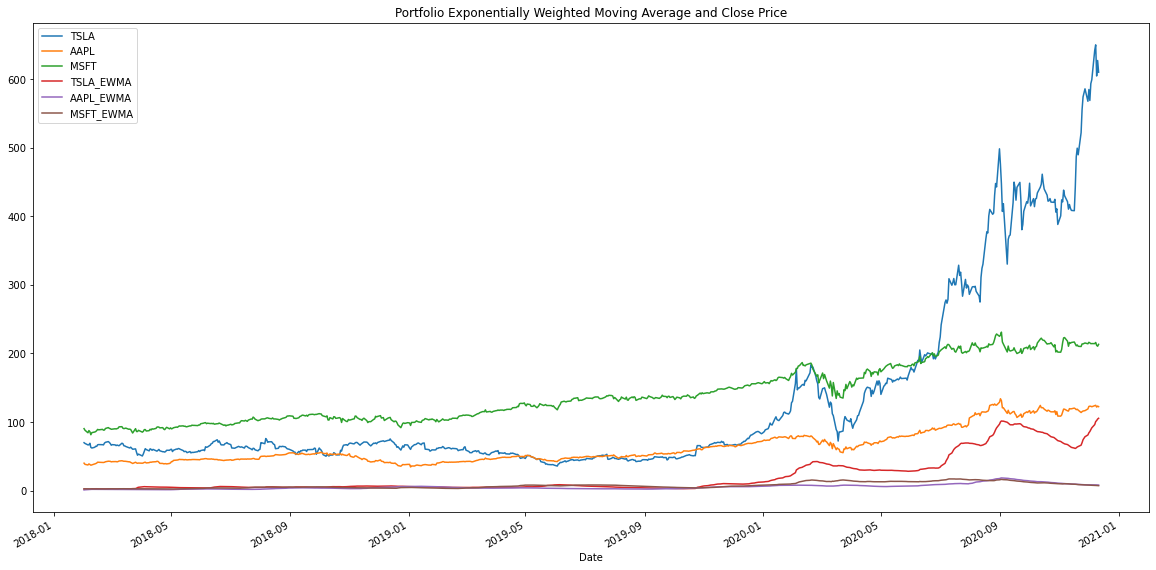

In [11]:
df_new.plot(figsize=(20,10),title='Portfolio Exponentially Weighted Moving Average and Close Price');

### Using Exponentially Weighted Moving Average with overlapping closing prices, what would be your action for the assets in the portfolio you created? 

# Risk Analysis and Portfolio Optimization

### Definition: Looking at individual assets, risk and return can be directly correlated. Often as risk increases the opportunity for a large return will also increase, but also a large loss. Looking at an entire portfolio a more risk adverse portfolio will be diverse and have stocks or assets that do not directly correlate with each other. 

### Purpose: Risk Analysis is a good tool to weigh the risk versus return for an entire portfolio or a single asset or security. 

In [12]:
#variables needed
#stocks = portfolio_returns
#weights
weights = np.full((1,len(portfolio_close.columns)), 1/len(portfolio_close.columns))[0].tolist()

#calculate the daily returns of our portfolio
portfolio_returns = portfolio_close.pct_change()
portfolio_returns.head(10)

,TSLA,AAPL,MSFT
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,-0.010233,-0.000174,0.004654
2018-01-04,-0.008290,0.004645,0.008802
2018-01-05,0.006230,0.011385,0.012398
2018-01-08,0.062638,-0.003714,0.001021
2018-01-09,-0.008085,-0.000115,-0.000680
2018-01-10,0.003326,-0.000229,-0.004534
2018-01-11,0.009409,0.005680,0.002961
2018-01-12,-0.005119,0.010327,0.017257


In [13]:
portfolio_returns = portfolio_returns.dropna().copy()
portfolio_returns.head()

,TSLA,AAPL,MSFT
Date,,,
2018-01-03,-0.010233,-0.000174,0.004654
2018-01-04,-0.008290,0.004645,0.008802
2018-01-05,0.006230,0.011385,0.012398
2018-01-08,0.062638,-0.003714,0.001021
2018-01-09,-0.008085,-0.000115,-0.000680


In [14]:
#calculate the a average return for each stock
portfolio_returns_avg_rtn = portfolio_returns.mean()
portfolio_returns_avg_rtn

TSLA    0.003966
AAPL    0.001718
MSFT    0.001492
dtype: float64

In [24]:
allocated_daily_returns = (weights * portfolio_returns_avg_rtn)

portfolio_return_pct = np.sum(allocated_daily_returns)
print(f"""

The daily percent return of the portfolio is {round(portfolio_return_pct*100,2)}%""")



The daily percent return of the portfolio is 0.24%


In [16]:
#add daily returns to our dataframe 
portfolio_returns['portfolio_daily_returns'] = portfolio_returns.dot(weights)
portfolio_returns.head()

,TSLA,AAPL,MSFT,portfolio_daily_returns
Date,,,,
2018-01-03,-0.010233,-0.000174,0.004654,-0.001918
2018-01-04,-0.008290,0.004645,0.008802,0.001719
2018-01-05,0.006230,0.011385,0.012398,0.010004
2018-01-08,0.062638,-0.003714,0.001021,0.019982
2018-01-09,-0.008085,-0.000115,-0.000680,-0.002960


In [17]:
#calculate cumulative returns
Cumulative_returns_daily = (1+portfolio_returns).cumprod()
Cumulative_returns_daily.head()

,TSLA,AAPL,MSFT,portfolio_daily_returns
Date,,,,
2018-01-03,0.989767,0.999826,1.004654,0.998082
2018-01-04,0.981562,1.004470,1.013496,0.999798
2018-01-05,0.987677,1.015906,1.026062,1.009800
2018-01-08,1.049543,1.012133,1.027109,1.029977
2018-01-09,1.041057,1.012017,1.026411,1.026929


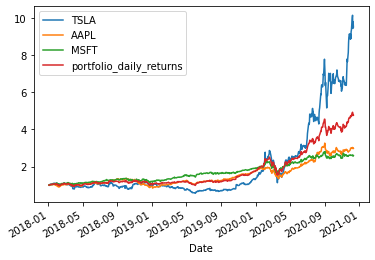

In [18]:
#plot cumulative returns for portfolio and individual stocks
Cumulative_returns_daily.plot();

In [19]:
Cumulative_returns_daily['portfolio_daily_returns'].sum()

1323.2165604786778

In [20]:
#calculate the covariance of the portfolio for risk analysis
#a positive covariance means the assets move in the same direction
#a negative covariance means the assets move in different directions and ultimately lowers your risk through diversivication

covariance_portfolio = portfolio_returns.iloc[:,:-1]
covariance_portfolio = (covariance_portfolio.cov())*252

covariance_portfolio

,TSLA,AAPL,MSFT
TSLA,0.468406,0.101505,0.099596
AAPL,0.101505,0.123746,0.088330
MSFT,0.099596,0.088330,0.105346


In [48]:
print(f"""This portfolio with equal weights has a return of {round(Cumulative_returns_daily['portfolio_daily_returns'].sum() - 100,2)}% 
and a risk of {round(portfolio_risk *100, 2)}%.""")

This portfolio with equal weights has a return of 1223.22% 
and a risk of 37.66%.


### Now we are going to optimize the portfolio to reduce the risk

In [29]:
#calculate the annual volatility for each asset

ann_volatility = portfolio_close.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_volatility

TSLA    0.680307
AAPL    0.350990
MSFT    0.323671
dtype: float64

In [35]:
#calculate portolio variance and volatility

portfolio_variance = np.dot(weights,np.dot(covariance_portfolio, weights))

#standard deviation (risk of portfolio)
portfolio_volatility = np.sqrt(portfolio_variance)

In [30]:
#calculate annual and expected returns for each asset 

ann_returns = portfolio_close.resample('Y').last().pct_change().mean()


In [31]:
#portfolio annual return percentage
port_er = (weights*ann_returns).sum()
port_er

1.5125288634333938

In [33]:
#create a table to display returns and volatility and rename columns
ret_vol_df = pd.concat([ann_returns, ann_volatility], axis=1)
ret_vol_df.columns = ['Returns', 'Volatility']
ret_vol_df

,Returns,Volatility
TSLA,3.273888,0.680307
AAPL,0.792588,0.350990
MSFT,0.471111,0.323671


In [51]:
# to optimize we need to run a loop that will randomly assign weights to each asset in our portfolio and calculate a new volatility. we will run the loop 10000 times 
# make an empty array for portfolio returns
portfolio_ret = [] 
# make an empty array for portfolio volatility
portfolio_vol = [] 
# make an empty array for asset weights
portfolio_weights = [] 

number_assets = len(portfolio_close.columns)
number_portfolios = 10000

for portfolio in range(num_portfolios):
    new_weights = np.random.random(num_assets)
    new_weights = new_weights/np.sum(new_weights)
    portfolio_weights.append(new_weights)
    new_returns = np.dot(new_weights, ann_returns) 
    
    portfolio_ret.append(new_returns)
    new_var = covariance_portfolio.mul(new_weights, axis=0).mul(new_weights, axis=1).sum().sum()
    sd = np.sqrt(new_var)
    ann_sd = sd*np.sqrt(250) 
    portfolio_vol.append(ann_sd)
    
    data = {'Port Returns':p_ret, 'Port Volatility':p_vol}
    
for counter, symbol in enumerate(df.columns.tolist()):
  
    data[symbol+' weight'] = [w[counter] for w in portfolio_weights]
    
    portfolios  = pd.DataFrame(data)
portfolios 

,Port Returns,Port Volatility,TSLA weight,AAPL weight,MSFT weight
0,1.442951,5.850513,0.410090,0.020590,0.569319
1,1.948131,6.885600,0.177383,0.348146,0.474471
2,0.941329,5.151803,0.020777,0.479916,0.499307
3,2.207812,7.502325,0.121582,0.598954,0.279464
4,1.015812,5.231147,0.700354,0.299112,0.000535
...,...,...,...,...,...
9995,1.646683,6.230577,0.521771,0.330459,0.147770
9996,1.226381,5.495375,0.121145,0.571594,0.307262
9997,1.624011,6.151321,0.176638,0.509447,0.313915
9998,1.749097,6.401404,0.403618,0.435852,0.160530


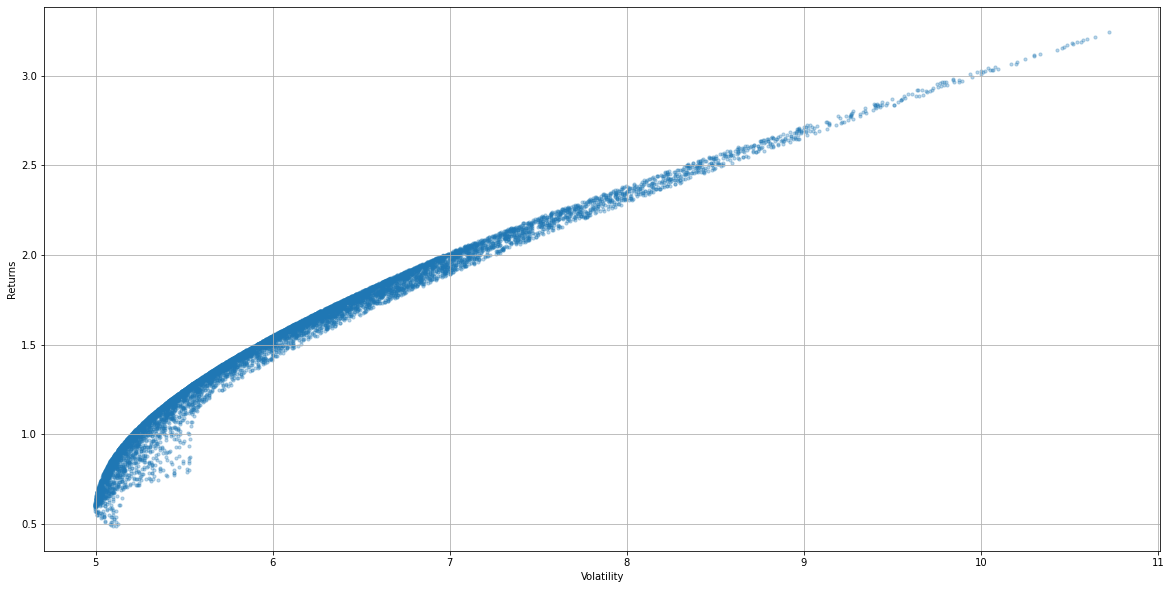

In [46]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[20,10]);

### The most risk averse portfolio will be the plot furthest to the left. The portfolio with the greatest return is the plot farthest to the right. How would you optimize your portfolio for the the greatest balance of risk and return? 